<a href="https://colab.research.google.com/github/allensheneka/predict-sales/blob/main/Predict_Sales_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# import key libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#import selectors, transformers, pipeline to clean and pre-process data
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

#import TTS
from sklearn.model_selection import train_test_split

#import linear regressor model
from sklearn.linear_model import LinearRegression
# Import the bagging regressor model
from sklearn.ensemble import BaggingRegressor
# Import random forest Regressor
from sklearn.ensemble import RandomForestRegressor

#import metrics to evaluate model effectiveness
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#import set_config to display a drawing of the ML process/pipeline
from sklearn import set_config
set_config(display='diagram')

In [3]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#upload data

filename = '/content/drive/MyDrive/Data Science/sales_predictions.csv'
df = pd.read_csv(filename)
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


##Quick Data Inspection Summary
Missing data in outlet size, maybe others

5 columns of numerical scales, i.e., item weight, item visibility, item MRP, outlet est year, item outlet sales

Nominal data:  item identifier, item fat content, item type, outlet type, outlet_location_type, outlet identifier

Ordinal data:  outlet size

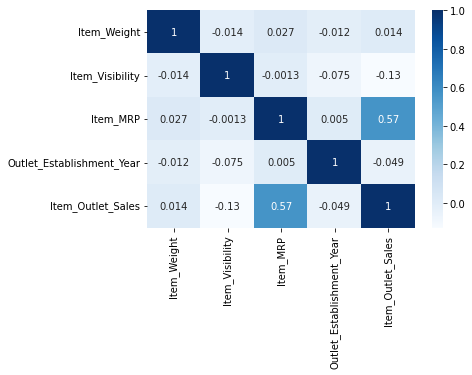

In [5]:
#  plot heatmap using "corr" variable for dataset
corr = df.corr()

# add correlation coefficients/numbers to heatmap with annot = True
sns.heatmap(corr, cmap = 'Blues', annot = True);

##Inspect Data

In [6]:
# overview of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [7]:
# inspect missing value total
df.isna().any(axis=1).sum()

3873

In [8]:
# total missing values in data columns
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [9]:
# inspect data rows and column count, i.e., shape
df.isna().shape

(8523, 12)

In [10]:
# inspect ordinal categories
df.Outlet_Size.value_counts()

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

3 ordinal categories for outlet size:  Small(0), Medium(1), High(2)

In [11]:
# Ordinal Encoding 'Outlet_Size'
replacement_dictionary = {'High':2, 'Medium':1, 'Small':0}
df['Outlet_Size'].replace(replacement_dictionary, inplace=True)

df['Outlet_Size']

0       1.0
1       1.0
2       1.0
3       NaN
4       2.0
       ... 
8518    2.0
8519    NaN
8520    0.0
8521    1.0
8522    0.0
Name: Outlet_Size, Length: 8523, dtype: float64

##Define X (features) and y (target)

In [12]:
# define X (features) and y (target)
X = df.drop(columns = 'Item_Outlet_Sales')
y = df['Item_Outlet_Sales']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

##Instantiate Transformers (Selectors, Imputers, OneHotEncoder)

In [13]:
# instantiate Selectors:  categorical (object) and numerical (number)
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

In [14]:
# instantiate Imputers:  categorical (most frequent) and numerical (mean)
freq_imputer = SimpleImputer(strategy='most_frequent')
mean_imputer = SimpleImputer(strategy='mean')

# instantiate Scaler
scaler = StandardScaler()

# instantiate One-hot encoder
# set 'sparse=False' to prevent returning Error on data that has not been fitted
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

##Instantiate Pipelines

In [15]:
# Numeric pipeline
# pass in (imputer, scaler) to combine into a pipeline
numeric_pipe = make_pipeline(mean_imputer, scaler)
numeric_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

In [16]:
# Categorical pipeline
# pass in (imputer, ohe) to combine into a pipeline
categorical_pipe = make_pipeline(freq_imputer, ohe)
categorical_pipe


Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

##Instantiate ColumnTransformer and Create one Preprocessing Object

In [18]:
# instantiate tuples for Column Transformer
# create tuple by passing in parameters (imputer, selector)
number_tuple = (numeric_pipe, num_selector)
category_tuple = (categorical_pipe, cat_selector)

# instantiate ColumnTransformer
# all preprocessing is in ONE preprocessing object
preprocessor = make_column_transformer(number_tuple, category_tuple)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f3237c52dd0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f3237c52c90>)])

In [19]:
# fit preprocessor on the training data
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f3237c52dd0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f3237c52c90>)])

In [20]:
# transform both the training and testing data (this will output a NumPy array)
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [21]:
# Check for missing values and that data is scaled and one-hot encoded
print(np.isnan(X_train_processed).sum().sum(), 'missing values in training data')
print(np.isnan(X_test_processed).sum().sum(), 'missing values in testing data')
print('\n')
print('All data in X_train_processed are', X_train_processed.dtype)
print('All data in X_test_processed are', X_test_processed.dtype)
print('\n')
print('shape of data is', X_train_processed.shape)
print('\n')

X_train_processed

0 missing values in training data
0 missing values in testing data


All data in X_train_processed are float64
All data in X_test_processed are float64


shape of data is (6392, 1593)




array([[ 0.81724868, -0.71277507,  1.82810922, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.5563395 , -1.29105225,  0.60336888, ...,  0.        ,
         1.        ,  0.        ],
       [-0.13151196,  1.81331864,  0.24454056, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 1.11373638, -0.92052713,  1.52302674, ...,  1.        ,
         0.        ,  0.        ],
       [ 1.76600931, -0.2277552 , -0.38377708, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.81724868, -0.95867683, -0.73836105, ...,  1.        ,
         0.        ,  0.        ]])

The preprocessed data looks good and ready for use with machine learning model.

Yea! No missing data.

All train and test data are floats. 

Training data rows reduced by ~25% from 8523 to 6392; columns increased from 12 to 1591.

##Linear Regression

In [22]:
# Make a linear regression model instance
lreg = LinearRegression()

# fit or train the model on the data; model learns the relationship between X and y
lreg.fit(X_train_processed,y_train)

LinearRegression()

In [23]:
# predict training and test PRICE
lreg_train_preds = lreg.predict(X_train_processed)
lreg_test_preds = lreg.predict(X_test_processed)

In [24]:
# calculate R^2 to determine effectiveness of model
lreg_r2_train = r2_score(y_train, lreg_train_preds)
lreg_r2_test = r2_score(y_test, lreg_test_preds)
print(lreg_r2_train)
print(lreg_r2_test)

0.6664056642852452
-5.828794128456094e+18


Model indicates VERY high variance - OVERFITTING - between training and test performance scores, so poor ability to predict prices using unknown dataset.

In [25]:
# calculate the RMSE
lreg_rmse_train = np.sqrt(mean_squared_error(y_train, lreg_train_preds))
lreg_rmse_test = np.sqrt(mean_squared_error(y_test, lreg_test_preds))
print(lreg_rmse_train)
print(lreg_rmse_test)

993.6084036625189
4010175883388.551


The linear regression RMSE results are way off here for both the preprocessed training and test dataset predicted PRICE.

##Bagging Regressor

In [26]:
# instantiate the model
bagreg = BaggingRegressor(random_state = 42)

# Looking at some parameters to tweak
bagreg.get_params()

{'base_estimator': None,
 'bootstrap': True,
 'bootstrap_features': False,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [27]:
# fit/train model on data
bagreg.fit(X_train_processed, y_train)

# see predicted values
bagreg_train_preds = bagreg.predict(X_train_processed)
bagreg_test_preds = bagreg.predict(X_test_processed)

# calculate new r2 for training and test data
bagreg_r2_train = r2_score(y_train, bagreg_train_preds)
bagreg_r2_test = r2_score(y_test, bagreg_test_preds)
print('Bagging Regressor')
print('R2 scores:')
print(bagreg_r2_train)
print(bagreg_r2_test)
print('\n')

# calculate the RMSE
bagreg_rmse_train = np.sqrt(mean_squared_error(y_train, bagreg_train_preds))
bagreg_rmse_test = np.sqrt(mean_squared_error(y_test, bagreg_test_preds))
print('RMSE values')
print(bagreg_rmse_train)
print(bagreg_rmse_test)

Bagging Regressor
R2 scores:
0.9190341708866963
0.5363350053163926


RMSE values
489.5046320935987
1131.0354501442764


Bagging Regressor improves model performance, but still VERY high variance - OVERFITTING issue.

In [28]:
# instantiate the model
rf = RandomForestRegressor(max_depth=10, random_state = 42)

# Looking at some parameters to tweak
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 10,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [29]:
# fit/train model on data
rf.fit(X_train_processed, y_train)

# see predicted values
rf_train_preds = rf.predict(X_train_processed)
rf_test_preds = rf.predict(X_test_processed)

# calculate new r2 for training and test data
rf_r2_train = r2_score(y_train, rf_train_preds)
rf_r2_test = r2_score(y_test, rf_test_preds)
print('Random Forest Regressor')
print('R2 scores:')
print(rf_r2_train)
print(rf_r2_test)
print('\n')

# calculate the RMSE
rf_rmse_train = np.sqrt(mean_squared_error(y_train, rf_train_preds))
rf_rmse_test = np.sqrt(mean_squared_error(y_test, rf_test_preds))
print('RMSE values')
print(rf_rmse_train)
print(rf_rmse_test)

Random Forest Regressor
R2 scores:
0.686947922168761
0.5966330362655939


RMSE values
962.5298735891539
1054.931415588121


Random Forest Regressor decreased variance considerably, but bias increased.  This is the model performance trade-off and I'll take it!!

##Visualizations

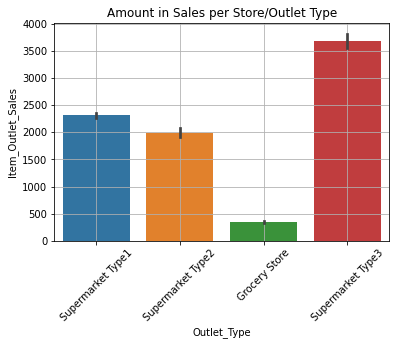

In [30]:
# created barplot to visually explain amount of sales per outlet type

# plot multiple data variables on a single chart
sns.barplot(data=df, x='Outlet_Type', y='Item_Outlet_Sales')
plt.grid()
plt.xticks(rotation=45)
plt.title("Amount in Sales per Store/Outlet Type");

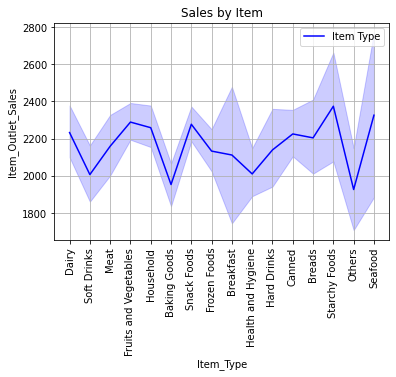

In [31]:
# line plot

# lines with legend
sns.lineplot(x = df['Item_Type'], y = df['Item_Outlet_Sales'], color = 'blue', label='Item Type')
plt.grid()
plt.legend()
plt.title('Sales by Item')
plt.xticks(rotation=90);